# Create our own blueprints

We may wish to customize DataRobot's blueprints. We can leverage Composable ML to build a new blueprint from scratch or swap out certain components for custom code.

# Background
This walkthrough uses a synthetic dataset that illustrates a credit card company’s AML compliance program, with the intent of detecting the following money-laundering scenarios:

* A customer spends on the card, but overpays their credit card bill and seeks a cash refund for the difference.
* A customer receives credits from a merchant without offsetting transactions, and either spends the money or requests a cash refund from the bank.

A rule-based engine is in place to produce an alert when it detects potentially suspicious activity consistent with the scenarios above. The engine triggers an alert whenever a customer requests a refund of any amount. Small refund requests are included because they could be a money launderer’s way of testing the refund mechanism or trying to establish refund requests as a normal pattern for their account.

The target feature is `SAR`. It indicates whether or not the alert resulted in an Suspicious Activity Report (SAR) after manual review by investigators, which means that this project is framed as a binary classification problem. The unit of analysis is an individual alert, so the model will be built on the alert level. Each alert will get a score ranging from 0 to 1, indicating the probability of being an alert leading to an SAR. The data consists of a mixture of numeric, categorical and text data.

# Setup

In [1]:
import os
import time
import warnings

import datarobot as dr
import matplotlib.pyplot as plt
import pandas as pd
import requests

%matplotlib inline
import seaborn as sns
from datarobot.enums import CUSTOM_TASK_TARGET_TYPE
from datarobot_bp_workshop import Visualize, Workshop
from src.helper import (
    draw_feature_histogram,
    get_top_of_leaderboard,
    plot_feature_impact,
)

warnings.filterwarnings("ignore")

# wider .head()s
pd.options.display.width = 0
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000

sns.set_theme(style="darkgrid")

RANDOM_SEED = 321

## Import data

In [2]:
# To read from a local file, uncomment and use:
# df = pd.read_csv('./data/DR_Demo_AML_Alert.csv')

# To read from an s3 bucket:
df = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_AML_Alert.csv"
)
df.head()

,ALERT,SAR,kycRiskScore,income,tenureMonths,creditScore,state,nbrPurchases90d,avgTxnSize90d,totalSpend90d,csrNotes,nbrDistinctMerch90d,nbrMerchCredits90d,nbrMerchCreditsRndDollarAmt90d,totalMerchCred90d,nbrMerchCreditsWoOffsettingPurch,nbrPayments90d,totalPaymentAmt90d,overpaymentAmt90d,overpaymentInd90d,nbrCustReqRefunds90d,indCustReqRefund90d,totalRefundsToCust90d,nbrPaymentsCashLike90d,maxRevolveLine,indOwnsHome,nbrInquiries1y,nbrCollections3y,nbrWebLogins90d,nbrPointRed90d,PEP
0,1,0,3,110300.0,5,757,PA,10,153.80,1538.00,,7,2,0,308.98,0,5,76.90,0.00,0,1,1,45.82,5,6000,0,3,0,6,1,0
1,1,0,2,107800.0,6,715,NY,22,1.59,34.98,card replace billing address billing address,11,2,0,3.28,1,4,60.00,25.02,1,2,1,67.40,0,10000,1,3,0,87,0,0
2,1,0,1,74000.0,13,751,MA,7,57.64,403.48,billing address customer call,4,0,0,0.00,0,4,796.63,393.15,1,2,1,450.69,0,10000,0,3,0,6,0,0
3,1,0,0,57700.0,1,659,NJ,14,29.52,413.28,,7,2,0,59.14,1,3,413.28,0.00,0,1,1,71.43,0,8000,1,5,0,7,2,0
4,1,0,1,59800.0,3,709,PA,54,115.77,6251.58,change request statement late payment bitcoin,16,7,2,785.85,2,3,8928.41,2676.83,1,2,1,2731.39,3,7000,1,1,0,8,1,0


## Connect to DataRobot

In [3]:
# To connect from Zepl notebook:
# dr.Client(token=z.getDatasource("datarobot_api")['token'], endpoint='https://app.datarobot.com/api/v2')

# To connect from Jupyter notebook:
dr.Client(
    token=os.environ["DATAROBOT_API_TOKEN"], endpoint=os.environ["DATAROBOT_ENDPOINT"]
)

# Create a DataRobot project using default settings

In [4]:
# Create a new project
project_bp_modification = dr.Project.create(
    sourcedata=df,
    project_name="DR_Demo_API_alert_AML_BP_Modification_{}".format(
        pd.datetime.now().strftime("%Y-%m-%d %H:%M")
    ),
)

# Set the project's target and initiate AutoPilot in Quick mode
project_bp_modification.set_target(
    target="SAR",
    mode="quick",
    worker_count=-1,
    advanced_options=dr.AdvancedOptions(seed=RANDOM_SEED),
)

# Open project's Leaderboard to monitor the progress in UI
project_bp_modification.open_leaderboard_browser()

# Wait for AutoPilot to finish. You can set verbosity to 0 if you do not wish to see progress updates
project_bp_modification.wait_for_autopilot(verbosity=1)

print(
    "Custom Project URL: "
    + "https://app.datarobot.com/projects/"
    + project_bp_modification.id
    + "/eda"
)
print("Custom Project ID: " + project_bp_modification.id)

In progress: 10, queued: 0 (waited: 0s)
In progress: 10, queued: 0 (waited: 1s)
In progress: 10, queued: 0 (waited: 1s)
In progress: 10, queued: 0 (waited: 2s)
In progress: 10, queued: 0 (waited: 3s)
In progress: 10, queued: 0 (waited: 5s)
In progress: 10, queued: 0 (waited: 9s)
In progress: 10, queued: 0 (waited: 16s)
In progress: 10, queued: 0 (waited: 29s)
In progress: 8, queued: 0 (waited: 50s)
In progress: 0, queued: 0 (waited: 70s)
In progress: 5, queued: 0 (waited: 91s)
In progress: 5, queued: 0 (waited: 111s)
In progress: 4, queued: 0 (waited: 132s)
In progress: 4, queued: 0 (waited: 152s)
In progress: 4, queued: 0 (waited: 173s)
In progress: 4, queued: 0 (waited: 193s)
In progress: 4, queued: 0 (waited: 214s)
In progress: 1, queued: 0 (waited: 234s)
In progress: 16, queued: 0 (waited: 255s)
In progress: 10, queued: 0 (waited: 275s)
In progress: 3, queued: 0 (waited: 296s)
In progress: 1, queued: 0 (waited: 316s)
In progress: 0, queued: 0 (waited: 337s)
In progress: 0, queued: 

In [5]:
# grab a completed project
project_bp_modification = dr.Project.get("62719f582cfd024f87957ea3")

# Let's customize our model pipeline!

## Initialize the Blueprint Workshop

In [6]:
w = Workshop()

## Let's first view the custom tasks available to us.

In [7]:
# List tasks registered in DataRobot
w.list_categories(show_tasks=True)

Custom

  - test_transform_custom (CUSTOMT_6143a63cbaca099dbb26a57a)
  - Write intermediate data (CUSTOMT_61f20e6e2533128c7d769052)
  - byoc_mission2 (CUSTOMC_614e388c12ed7c086b26a48f)
  - byoc_mission2_wip (CUSTOMC_6151f67135d743f97aa85b00)
  - byoc_mission2_update (CUSTOMC_617b1031ffeb5d9835d0d600)
  - updated_werkzog (CUSTOMC_617c16444849732495b447d0)
  - CatBoost Binary Classifier for Demo (CUSTOMC_61a937ed87b42b53e24e2b81)
  - CatBoost Binary Classifier for Demo (CUSTOMC_6201a246718c83c56225b998)
  - Passthrough estimator for sentiment predictor (CUSTOMR_61b22630efdb81c459534520)
  - Passthrough estimator for sentiment predictor (CUSTOMR_61b3cbb68dc05265646e4c63)
  - Write intermediate data for regressor (CUSTOMR_61f213c8400e8969dd7690a9)
  - Passthrough estimator for sentiment predictor mh (CUSTOMR_61b3ce58c59163797238f39f)
Preprocessing

  Numeric Preprocessing

    Data Quality

      - Numeric Data Cleansing (NDC)
      - Missing Values Imputed (arbitrary or quick median) (PNI

In [20]:
# Understand what each task is doing
print(w.Tasks.PLSC.documentation())
help(w.Tasks.PLSC)

https://app.datarobot.com/model-docs/tasks/PLSC-Partial-Least-Squares-Classification.html
Help on PLSC in module datarobot_bp_workshop.factories object:

class PLSC(datarobot_bp_workshop.friendly_repr.FriendlyRepr)
 |  Partial Least-Squares Classification
 |  
 |  Partial Least Squares Classification. Similar to PCA classification. This method projects the variables into a new space. Based on scikit-learn Lasso
 |  
 |  Parameters
 |  ----------
 |  output_method: string, one of (TaskOutputMethod.PREDICT, TaskOutputMethod.STACK).
 |  task_parameters: dict, which may contain:
 |  
 |    copy (copy): select, (Default=1)
 |      Possible Values: [False, True]
 |  
 |    max_iter (mi): int, (Default=500)
 |      Possible Values: [1, 1000000]
 |  
 |    n_components (nc): multi, (Default='auto')
 |      Possible Values: {'intgrid': [1, 100.0], 'select': ['auto']}
 |  
 |    scale (sc): select, (Default=1)
 |      Possible Values: [False, True]
 |  
 |    tol (e): float, (Default='1e-6')
 | 

## Define a CatBoost estimator

### Select execution environment

In [ ]:
# while we can create our own environment, DataRobot offers a number of drop-in choices
execution_environments = dr.ExecutionEnvironment.list()
for execution_environment in execution_environments:
    print(execution_environment)

We'll use the scikit-learn drop-in environment when defining our custom CatBoost classifier. More information on this environment can be found [here](https://github.com/datarobot/datarobot-user-models/tree/master/public_dropin_environments/python3_sklearn) on GitHub.

In [ ]:
# select the scikit-learn drop-in environment
for execution_environment in execution_environments:
    if execution_environment.name == "[DataRobot] Python 3 Scikit-Learn Drop-In":
        BASE_ENVIRONMENT = execution_environment
        break

### Point to CatBoost custom code

The code for a CatBoost classifier can be found on our Community GitHub repo: https://github.com/datarobot-community/custom-models/tree/master/custom_tasks/models/classification/python/catboost.

In [22]:
# define our new classifier
binary_classifier = dr.CustomTask.create(
    name="CatBoost Binary Classifier for Demo",
    target_type=CUSTOM_TASK_TARGET_TYPE.BINARY,
)

# pull in catboost code
custom_task_folder = "catboost/"
task_version = dr.CustomTaskVersion.create_clean(
    custom_task_id=binary_classifier.id,
    base_environment_id=BASE_ENVIRONMENT.id,
    folder_path=custom_task_folder,
)

binary_classifier.refresh()  # In order to see the change, you need to GET it from DataRobot
binary_classifier.latest_version

CustomTaskVersion('v1.0')

In [ ]:
# build the dependencies
# this can take a few minutes
build_info = dr.CustomModelVersionDependencyBuild.start_build(
    custom_model_id=binary_classifier.id,
    custom_model_version_id=task_version.id,
    max_wait=3600,  # 1 hour timeout
)

build_info.build_status

In [ ]:
# look for the newly created task
w.refresh()
w.search_tasks("catboost")

## Add new CatBoost estimator to our top-performing blueprint

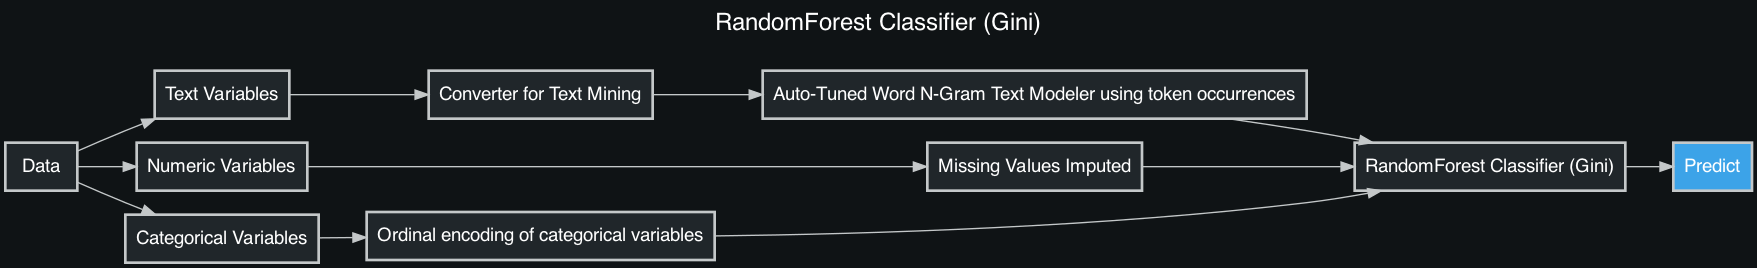

In [15]:
# grab best blueprint from the leaderboard
w.set_project(project_id=project_bp_modification.id)
models = w.project.get_models()
blueprint_id = models[0].blueprint_id
Visualize.show_dr_blueprint(dr.Blueprint.get(project_bp_modification.id, blueprint_id))

In [16]:
# add new estimator to best blueprint from the leaderboard
bp = w.clone(blueprint_id=blueprint_id)
print(bp.to_source_code())
# we'll need to copy the output and insert our new custom task

w = Workshop(user_blueprint_id='627aa6117dc2173da8f24c5e', project_id='62719f582cfd024f87957ea3')

csrnotes = w.Features.csrNotes

pnia4 = w.Tasks.PNIA4(w.TaskInputs.NUM)

ordcat2 = w.Tasks.ORDCAT2(w.TaskInputs.CAT)
ordcat2.set_task_parameters(m='random')

wngec2 = w.Tasks.WNGEC2(csrnotes, output_method=w.TaskOutputMethod.STACK)
wngec2.set_task_parameters(bi=True, a=0, lc=True, madf=0.8, midf=2, nrm='l2', num=[1, 2], tol=0, uidf=False)

rfc = w.Tasks.RFC(wngec2, pnia4, ordcat2)
rfc.set_task_parameters(e='RandomForestClassifier', mf=[0.2, 0.3, 0.4], ml=2000, ls=[5, 10, 20])

rfc_blueprint = w.BlueprintGraph(rfc, name='RandomForest Classifier (Gini)')


In [17]:
# this code was copied from the output of the previous cell and modified to include the CatBoost estimator
w = Workshop(
    user_blueprint_id="6274525c1fb35178d1f248a5", project_id="62719f582cfd024f87957ea3"
)

csrnotes = w.Features.csrNotes

pnia4 = w.Tasks.PNIA4(w.TaskInputs.NUM)

ordcat2 = w.Tasks.ORDCAT2(w.TaskInputs.CAT)
ordcat2.set_task_parameters(m="random")

wngec2 = w.Tasks.WNGEC2(csrnotes, output_method=w.TaskOutputMethod.STACK)
wngec2.set_task_parameters(
    bi=True, a=0, lc=True, madf=0.8, midf=2, nrm="l2", num=[1, 2], tol=0, uidf=False
)

cbc = w.CustomTasks.CUSTOMC_61a937ed87b42b53e24e2b81(wngec2, pnia4, ordcat2)
# rfc.set_task_parameters(e='RandomForestClassifier', mf=[0.2, 0.3, 0.4], ml=2000, ls=[5, 10, 20])

cbc_blueprint = w.BlueprintGraph(cbc, name="Catboost Classifer")

In [25]:
# train the newly created CatBoost blueprint
cbc_blueprint.train(project_id=project_bp_modification.id, sample_pct=64)

Training requested! Blueprint Id: 1c381d53755b97da1b0f9382c17abffc


Name: 'Catboost Classifer'

Input Data: Text | Numeric | Categorical
Tasks: Single Column Converter, Select Feature: 'csrNotes' | Missing Values Imputed (arbitrary or quick median) | Ordinal encoding of categorical variables | Auto-Tuned N-Gram Text Modeler using token counts | CatBoost Binary Classifier for Demo
Linked Project Id: 62719f582cfd024f87957ea3